In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Saddle-node bifurcations

64 133 3 0 1
0.148200	1.000000e-02	1483	
Changed too much!	14.810000 	1.000000e-02	0.063	0.887	0
0.148450	5.000000e-03	1494	
Changed too much!	14.840000 	5.000000e-03	0.057	0.896	0
0.148625	2.500000e-03	1507	
Changed too much!	14.860000 	2.500000e-03	0.059	0.893	0
0.148837	2.500000e-03	1526	
Second branch not found!	14.883750	2.500000e-03	1	1	0.191836	2.225062	0	0	0	
0.148825	1.250000e-03	1527	
Second branch not found!	14.882500	1.250000e-03	1	1	1.077394	0.252354	0	0	0	
0.148819	6.250000e-04	1528	
Second branch not found!	14.881875	6.250000e-04	1	1	1.170922	0.246174	0	0	0	
0.148816	3.125000e-04	1529	
Second branch not found!	14.881562	3.125000e-04	1	1	1.214048	0.252458	0	0	0	
0.148814	1.562500e-04	1530	
Second branch not found!	14.881406	1.562500e-04	1	1	0.177169	1.234733	0	0	0	
0.148813	7.812500e-05	1531	
Second branch not found!	14.881328	7.812500e-05	1	1	0.886462	0.250307	0	0	0	
0.148813	3.906250e-05	1532	
Second branch not found!	14.881289	3.906250e-05	1	1	0.251925	0.934589	0	0	0	


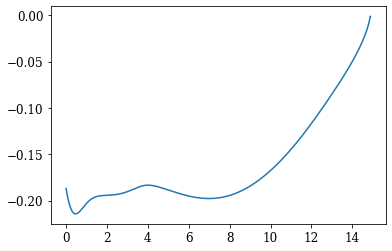

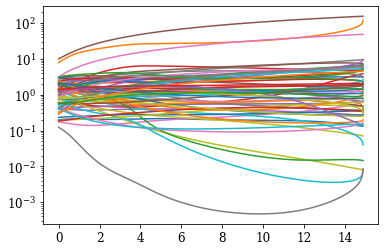

In [176]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.05*n)
na=int(0.0*nr)
seed=1
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=3,depmin=1e-14,stop=False)
stop=timeit.default_timer()
print(stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

85 1945.609316922413 2.036580658151398e-05


/Users/zack/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/scipy/integrate/_ode.py:1352: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.000033	0.000000	177090	99	lsoda	
Found oscillating state!
True 255.7180695570005


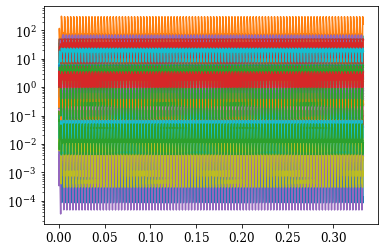

3270 177701


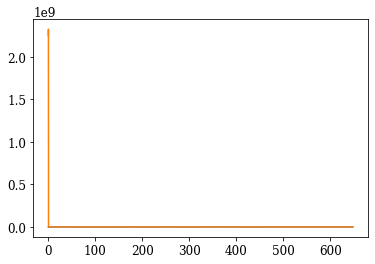

3225.684700250744 37899.65852188315 3225.6846998125184 37880.044710043425 138.29912365398835 3451.443631899042


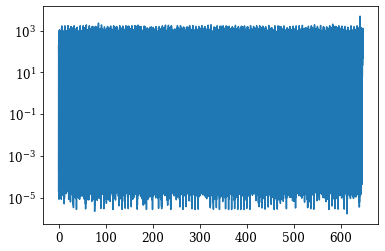

1


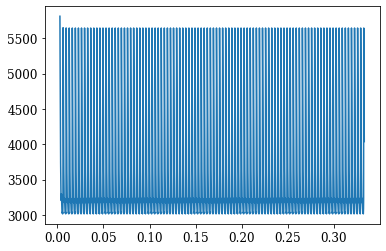

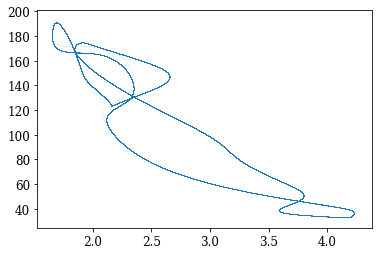

In [146]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)

epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [143]:
success,solx=rmtchem.steady(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2)
print(success,np.linalg.norm((solx-Xts[:,-1])/solx))
ev,evecs=np.linalg.eig(rmtchem.jac(0,solx,eta,nu,k,(1+epsilon)*XD1,XD2))
print(ev[np.argmax(np.real(ev))])

True 0.0
(-0.032725471027520395+0j)


0.090336	-4.882813e-06	20		
Saddle-node bifurcation!	13.550347	-4.882813e-06	1	1	4.486498	0.000006	0	1	0	
0.090345	7.812500e-05	64	
Saddle-node bifurcation!	13.551758	7.812500e-05	1	1	7.121234	1.996437	1	0	0	
0.090337	-3.906250e-05	78	
Saddle-node bifurcation!	13.550625	-3.906250e-05	1	1	5.333673	0.000004	0	1	0	
0.090345	7.812500e-05	94	
Saddle-node bifurcation!	13.551758	7.812500e-05	1	1	7.121277	1.996448	1	0	0	
0.090339	-7.812500e-05	107	
Saddle-node bifurcation!	13.550820	-7.812500e-05	1	1	5.655883	0.000000	0	1	0	
0.090345	3.906250e-05	121	
Saddle-node bifurcation!	13.551758	3.906250e-05	1	1	7.945017	2.227385	1	0	0	
0.090340	-7.812500e-05	133	
Saddle-node bifurcation!	13.551016	-7.812500e-05	1	1	0.000001	5.871518	0	0	1	
0.090345	1.953125e-05	148	
Saddle-node bifurcation!	13.551816	1.953125e-05	1	1	0.000000	2.768945	1	1	0	


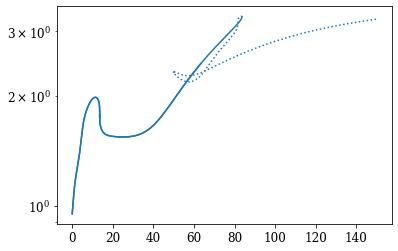

In [144]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif2=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,1e-2,output=2,stepsmax=5000,stop=False)
X3s,epsilon3s,eval3s,bif3=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,-1e-2,output=2,stepsmax=5000,stop=False)


plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval2s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval2s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval3s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval3s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

### Hopf bifurcations

64 133 3 0 145
0.435360	1.000000e-03	43537	
Supercritical Hopf bifurcation!		43.537000
0.439864	6.250000e-05	44010	
Saddle-node bifurcation!	43.986437	6.250000e-05	1	1	0.000003	2.049708
0.422519	-6.250000e-05	45792	
Saddle-node bifurcation!	42.251937	-6.250000e-05	1	1	1.992014	0.000000


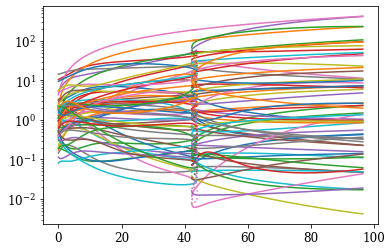

In [11]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.05*n)
na=0
seed=145
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-3,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

(1.69054690222787e-11+0.08377601124852978j)
54.11284611486189 371665837777.0741 5.510808974978594
0.000000	0.000000	1875	20	lsoda	
Found steady state!
True 1.4563550680031767


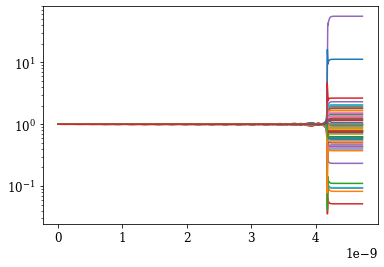

2031 2032


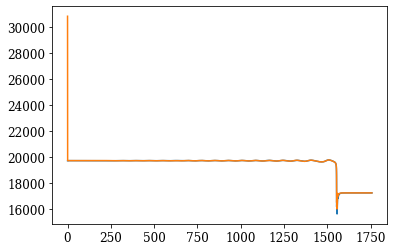

19746.77148342004 17264.514563208962 19746.771483409677 17264.514563210803 55.709833585213744 -0.12570444349828291


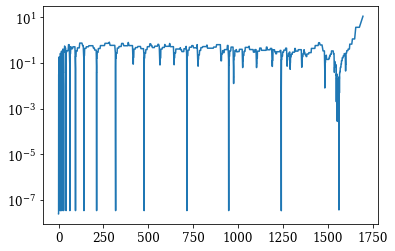

0


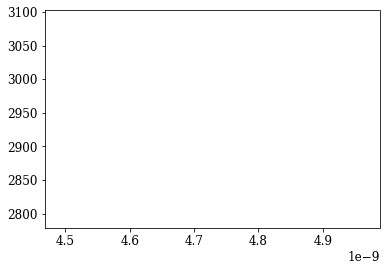

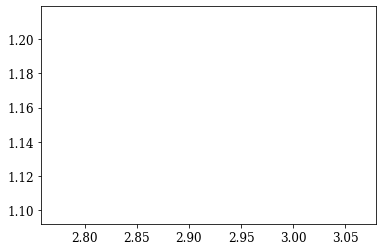

In [169]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-3
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
ind=np.argmax(np.real(ev))
print(ev[ind])
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,cont=False)
# ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,tscale,dt,output=True,cont=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


68.79999999999826 5309.36153279411 0.13840321272552658
0.000001	0.000000	13672	20	lsoda	
Found oscillating state!
True 13.941591623000022


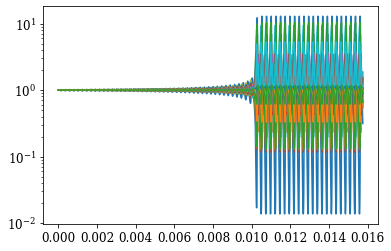

In [23]:
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon=epsilons[m0]+1e0
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=20)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()

### Chemical chaos 

64 133 6 66 1010
0.106300	1.000000e-02	1064	
Hopf bifurcation!		10.640000
0.144150	1.000000e-02	1469	
Hopf bifurcation!		14.425000
0.182150	1.000000e-02	1849	
Hopf bifurcation!		18.225000
0.262623	7.812500e-05	2700	
Saddle-node bifurcation!	26.262305	7.812500e-05	1	1	0.000000	2.058547
0.140437	-7.812500e-05	4039	
Saddle-node bifurcation!	14.043711	-7.812500e-05	1	1	1.895819	0.000000
0.150225	1.000000e-02	4192	
Hopf bifurcation!		15.032539
0.659767	3.906250e-05	9324	
Saddle-node bifurcation!	65.976680	3.906250e-05	1	1	0.000000	1.898244
0.203756	-3.906250e-05	14016	
Saddle-node bifurcation!	20.375625	-3.906250e-05	1	1	0.000000	2.036451
0.213051	1.000000e-02	14176	
Hopf bifurcation!		21.315117
0.557075	7.812500e-05	17657	
Saddle-node bifurcation!	55.707539	7.812500e-05	1	1	0.000000	2.020000
0.256068	-3.906250e-05	20767	
Saddle-node bifurcation!	25.606758	-3.906250e-05	1	1	0.000000	2.499468
0.452314	3.906250e-05	22821	
Saddle-node bifurcation!	45.231406	3.906250e-05	1	1	0.000000	1.196077
0

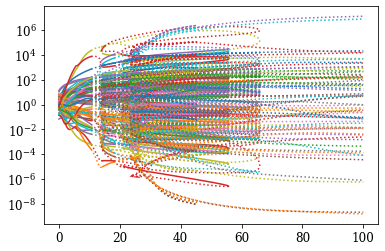

In [32]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=89

#64 133 12 66 505
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=1010
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

20 57.854048340635465 0.00012097183746864335


/Users/zack/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/scipy/integrate/_ode.py:1352: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


/Users/zack/Documents/rmtchem/rmtchem.py:137: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.016233	0.000209	6086	99	irk  	Unexpected istate in LSODA.
Found oscillating state!
True 10.16612198599978


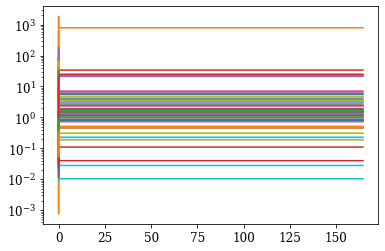

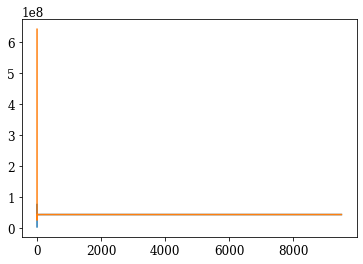

2678823.1087422646 2678823.108742265 634193247.0682617 634193247.0682617


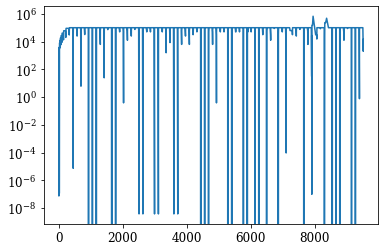

1


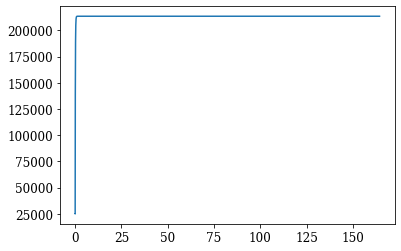

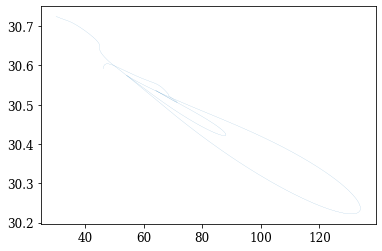

In [109]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=epsilons[m0]+1e-1
epsilon=20
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
# ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,tscale,dt,output=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


/Users/zack/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/scipy/integrate/_ode.py:1352: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.946905	0.053095	4829	10	irk  	Unexpected istate in LSODA.
Failed to find state before maxtime 578.5404834063546


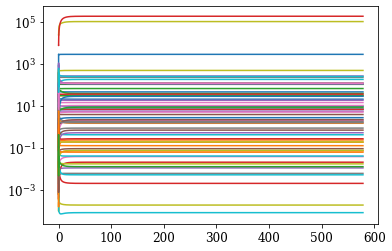

/Users/zack/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/scipy/integrate/_ode.py:1352: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


0.315358	0.157679	476934	0	irk  	Unexpected istate in LSODA.
Found steady state!
4.73037464064426 True


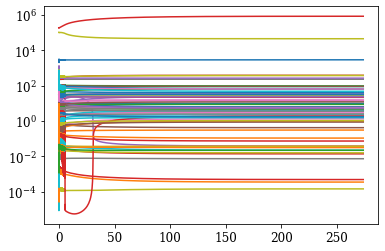

In [145]:
imp.reload(rmtchem)
np.random.seed(1)
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,10*dt,output=True,cont=True)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()
ts,Xts,success,m0,state=rmtchem.integrate(Xts[:,-1]*(1+1e-2*(0.5-np.random.random(size=len(X0)))),eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,dt,output=True,cont=False,maxsteps=1e7)
print(ts[-1]/tscale,success)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()

In [146]:
success,solx=rmtchem.steady(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2)
print(success,np.linalg.norm((solx-Xts[:,-1])/solx))
ev,evecs=np.linalg.eig(rmtchem.jac(0,solx,eta,nu,k,(1+epsilon)*XD1,XD2))
print(ev[np.argmax(np.real(ev))])

True 0.004443704746633037
(-0.02285580152044904+0j)


0.365176	1.000000e-02	1808	
Hopf bifurcation!		36.527578
0.366577	1.562500e-04	1899	
Saddle-node bifurcation!	36.657734	1.562500e-04	1	1	0.000015	2.093747
0.061400	-1.000000e-02	1387	
Hopf bifurcation!		6.130000
0.061388	-9.765625e-06	1408	
Saddle-node bifurcation!	6.138779	-9.765625e-06	1	1	1.184583	0.000000
0.366577	1.562500e-04	4741	
Saddle-node bifurcation!	36.657744	1.562500e-04	1	1	0.000029	1.946876
0.365093	-1.000000e-02	4806	
Hopf bifurcation!		36.499307


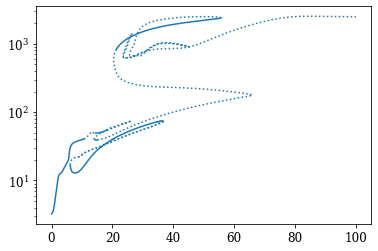

In [35]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif2=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,1e-2,output=2,stepsmax=5000,stop=False)
X3s,epsilon3s,eval3s,bif3=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,-1e-2,output=2,stepsmax=5000,stop=False)


plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval2s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval2s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval3s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval3s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [36]:
np.save('data/chaos/Xs1.npy',Xs)
np.save('data/chaos/epsilons1.npy',epsilons)
np.save('data/chaos/evals1.npy',evals)
np.save('data/chaos/Xs2.npy',X2s)
np.save('data/chaos/epsilons2.npy',epsilon2s)
np.save('data/chaos/evals2.npy',eval2s)
np.save('data/chaos/Xs3.npy',X3s)
np.save('data/chaos/epsilons3.npy',epsilon3s)
np.save('data/chaos/evals3.npy',eval3s)

13 57.854048340635465 0.0004782726232409825
0.107334	0.118861	210373	10	lsoda	xpected istate in LSODA.
Found oscillating state!
True 338.0724468460103


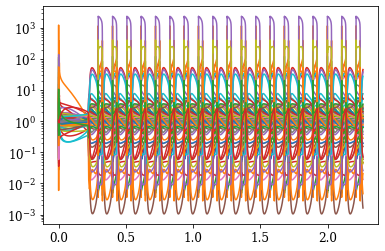

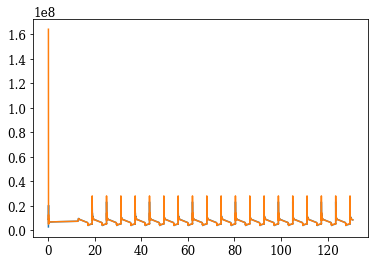

2678823.1087422646 2678823.1087422636 157321513.7655056 157321513.76550558


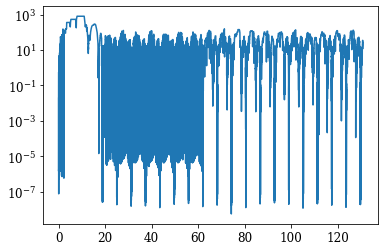

1


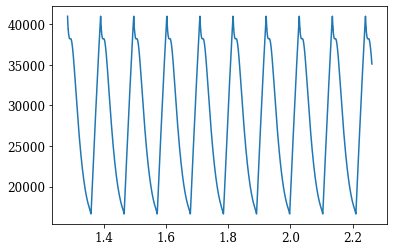

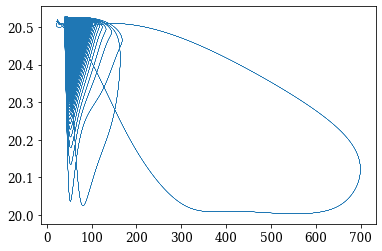

In [157]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=epsilons[m0]+1e-1
epsilon=13
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
# ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,10*tscale,dt,output=True,maxcycles=10)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [158]:
np.save('data/chaos/ts.npy',ts)
np.save('data/chaos/Xts.npy',Xts)

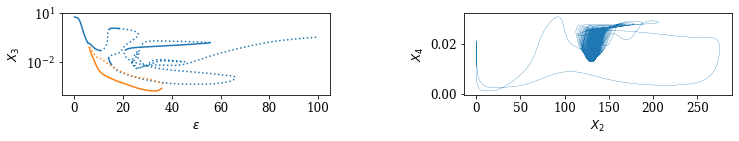

In [416]:
Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')
ts=np.load('data/chaos/ts.npy')
Xts=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=2*np.pi/(np.imag(evals[m,np.argmax(np.real(evals[m]))]))*500

lst=range(n)
lst=[3]

plt.subplots(1,2,figsize=(12,1.5))

plt.subplot(1,2,1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_3$')
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])

ax=plt.subplot(1,2,2)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$X_4$')
tinds=np.where(ts>tmax/10)[0]
ind1=2
ind2=4
plt.plot(Xts[ind1,tinds],Xts[ind2,tinds],zorder=-1,linewidth=0.01,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3c.pdf',dpi=300)
plt.show()

### Empirical reaction network stoichiometry

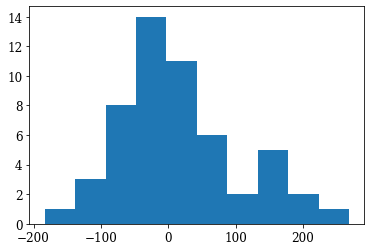

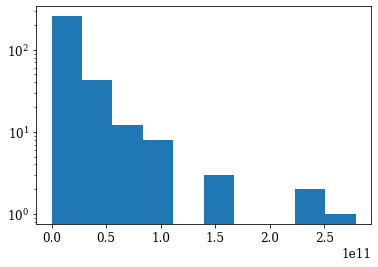

In [37]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

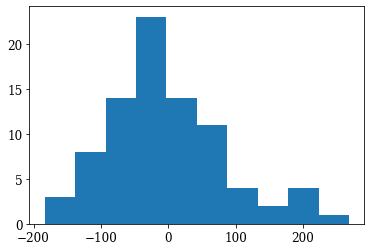

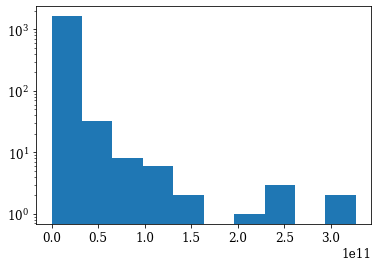

In [38]:
gas=ct.Solution('pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()